# Introduction to Data Analysis Techniques for Cosmic Microwave Background  Maps

### Jeff McMahon Renée Hložek, updated by Vivian Sabla

The Cosmic Microwave Background (CMB) is the oldest observable light in the universe. As such it carries a wealth of cosmological information including: (1) signals from the early universe (primary anisotropy), and (2) distortions imprinted as this light propagates through the universe and encounters collapsed structures (secondary anisotropy).  Measurements of these signals give us important measurements and constraints on inflationary parameters, dark energy, dark matter, the sum of the neutrino masses, and many astrophysical processes.  The development of CMB instruments and analysis techniques is rapidly evolving.

This notebook provides an introduction to the CMB angular power spectra of temperature fluctuations. We cover how the cosmological parameters influence the expected signal and compare spectra produced in different cosmologies to the spectra measured by CMB experiments.

For simplicity we consider only temperature fluctuations in this notebook, but all work done can be easily extrapolated to investigate polarization and cross-spectra. 

# Code Preliminaries

We will use the Cosmic Linear Anisotropy Solving System (CLASS), first written by Julien Lesgourgues, Thomas Tram, and Nils Schoeneberg, in order to compute the CMB angular power spectrum. Information, documentation, and links to the original papers on CLASS can be found at https://lesgourg.github.io/class_public/class.html. 

In [1]:
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import astropy.io.fits as fits
from classy import Class
import sys
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import inspect
class_module_path = inspect.getfile(Class)
print("Class module is imported from:", class_module_path)

Class module is imported from: /Users/Viv/.local/lib/python3.10/site-packages/classy-3.2.1-py3.10-macosx-10.9-x86_64.egg/classy.cpython-310-darwin.so


# Section 1.1: Angular Power Spectrum
The majority of the information content of the CMB is contained in its angular power spectrum.   This spectrum is the amplitude squared of the magnitude of the temperature fluctuations as a function of $\ell$.  Here $\ell$ is the variable you have seen before with the spherical harmonics (e.g., $Y_{\ell m}$).  $\ell = 0$ corresponds to a constant temperature across the sky, $\ell = 200$ corresponds approximately to scales of $1^\circ$.  For a given set of input cosmological parameters these spectra can be computed with codes including CMBFAST or the more modern equivalent CAMB or CLASS.  

It is fun to play with parameters and see how the spectrum changes. 

The relative locations and amplitudes of the peaks carry a great deal of information.  The location of the first peak at $\ell \sim 200$ provided the first definitive measurement that our universe is flat.  The shape of the spectrum constraints a wide variety of cosmological parameters including dark energy and dark matter.  The fall off at high ell (e.g. $\ell \gtrsim 1000$ is called the damping tail and it provides constrains on the spectral index from inflation.  A wealth of cosmological parameters are constrained by measurements of this spectrum.  

CLASS takes inputs in the form of a dictionary. Relevant inputs are all explained in depth in: https://github.com/lesgourg/class_public/blob/master/explanatory.ini. 
Here we set our cosmology to match the best-fit model from $Planck$ 2018 $\texttt{TTTEEE+lowE+lensing}$ (see https://arxiv.org/abs/1807.06209).  

The physics of cosmological perturbation theory (which CLASS and other Boltzmann solvers are based on) is compiled quite nicely by Ma and Bertschinger in https://arxiv.org/pdf/astro-ph/9506072.

In [3]:
lcdm_params = {
        'output':'mPk,tCl,lCl,dTk',
        'h':0.6736,
        'omega_b':0.02237,   
        'omega_cdm':0.1200,  
        'A_s':2.100e-9,
        'n_s':0.9649,
        'tau_reio':0.0544,
        'YHe':'BBN',
        'l_max_scalars':5000,
        'k_output_values': '0.1, 0.01, 0.001',
        'P_k_max_1/Mpc':10.0,
        'lensing':'yes',
        'gauge':'synchronous'}

In [4]:
lcdm = Class()
lcdm.set(lcdm_params)
lcdm.compute()

In [5]:
ell, cl_tt = lcdm.lensed_cl()['ell'], lcdm.lensed_cl()['tt']

ell_fac = (lcdm.T_cmb()*1e6)**2*ell*(ell+1)/(2*np.pi) #Tcmb*1e6 to add familiar dimesions (K to \micro K conversion)

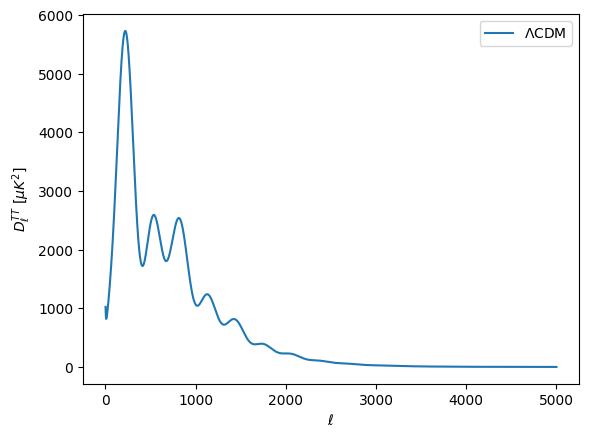

In [6]:
plt.plot(ell[2:],cl_tt[2:]*ell_fac[2:], label='$\Lambda$CDM' )
plt.xlabel('$\ell$')
plt.ylabel('$D_\ell^{TT}$ [$\mu K^2$]')
plt.legend()

This plot is the angular power spectrum of the CMB temperature anisotropies.  It is traditional to plot $D_\ell$ which give the variance on various angular scales.  This is related to the angular power spectrum $C_\ell$ by $D_\ell = \frac {\ell (\ell+1)} {2 \pi} C_\ell$.  The correct thing to use for creating CMB maps is $C_\ell$, but $D_\ell$ is what you are used to seeing plotted.

<font color='red'> EXERCISE 1.1: </font>  Generate a CMB power spectrum for a model unvierse with an odd distribution of energy or a strange component of your choosing (e.g., with spatial curvature, no dark energy, some other bizarre component). Look through the CLASS documentation to see what kinds of alternative cosmologies are built in, or play with the standard model parameters. Make a plot comparing your cosmology to the vanilla $\Lambda$-CDM spectrum above.

Save your alternative CMB spectrum to a file for later use.

In [7]:
# YOUR CODE GOES HERE

Comment on how your spectrum from this strange model universe compares to the spectrum from standard cosmology here.

<font color='red'> EXTRA CREDIT: </font>  Generate CMB power spectra for universes with each of the six standard model parameters varied by $\pm$ 20\%. Can you give physics explanations for why the power spectra changes as it does for each case?

In [8]:
# YOUR CODE GOES HERE

#### Comparison with Data
Now let's compare this computed theoretical spectrum with some data. We will load in the binned Planck 2018 temperature spectra (found on the Planck Legacy Archive @ http://pla.esac.esa.int/pla), and the binned ACT DR4 temperature spectra (found on https://lambda.gsfc.nasa.gov/product/act/index.html). These are located in the directory `cmb_spectra`.

In [9]:
p18_ell, p18_Dl, p18_sigDl = np.loadtxt('obs_cmb_spectra/planck18_TT_binned.txt')[:,:3].T
act_ell, act_Dl, act_sigDl = np.loadtxt('obs_cmb_spectra/actdr4_TT_binned.txt').T

In [10]:
from scipy.interpolate import interp1d as i1d

fTT = i1d(ell[2:],cl_tt[2:]*ell_fac[2:],kind='cubic',bounds_error=False,fill_value='extrapolate')

p18_res_TT_val = (p18_Dl-fTT(p18_ell))/fTT(p18_ell)
p18_res_TT_err = np.sqrt( ( p18_sigDl / ( p18_Dl - fTT(p18_ell) ) )**2 ) * np.abs( p18_res_TT_val )
p18_res_TT = np.column_stack((p18_ell, p18_res_TT_val, p18_res_TT_err))

act_res_TT_val = (act_Dl-fTT(act_ell))/fTT(act_ell)
act_res_TT_err = np.sqrt( ( act_sigDl / ( act_Dl - fTT(act_ell) ) )**2 ) * np.abs( act_res_TT_val )
act_res_TT = np.column_stack((act_ell, act_res_TT_val, act_res_TT_err))

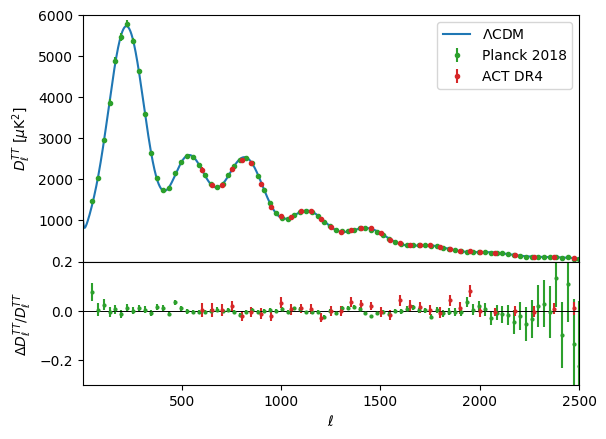

In [11]:
fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2,hspace=0,height_ratios=[2,1])

ax = fig.add_subplot(gs[0,0])
ax.plot(ell[2:],cl_tt[2:]*ell_fac[2:],label='$\Lambda$CDM')
plt.errorbar(p18_ell, p18_Dl, yerr=p18_sigDl, fmt='o', label='Planck 2018',ms=3,color=color[2])
plt.errorbar(act_ell, act_Dl, yerr=act_sigDl, fmt='o', label='ACT DR4',ms=3,color=color[3])
ax.set_xlim(2,2500)
ax.set_ylim(1,6000)
ax.set_xticks([])
ax.legend(loc='upper right')
ax.set_ylabel(r'$D_\ell^{TT}$ [$\mu{\rm K}^2$]')

ax = fig.add_subplot(gs[1,0])
ax.errorbar(p18_res_TT[:,0],p18_res_TT[:,1],yerr=p18_res_TT[:,2],xerr=None,fmt='o',ms=2,color=color[2])
ax.errorbar(act_res_TT[:,0],act_res_TT[:,1],yerr=act_res_TT[:,2],xerr=None,fmt='o',ms=2,color=color[3])
ax.axhline(0,color='k',lw=0.7)
ax.set_xlim(2,2500)
ax.set_ylim(-0.3,0.2)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\Delta D_\ell^{TT}/D_\ell^{TT}$');


The above plot shows the $\Lambda$-CDM model,  and the Planck 2018 and ACT DR4 data points. The residuals are shown in the lower panel. The residuals are calculated as $\Delta D_\ell^{TT}/D_\ell^{TT} = (D_\ell^{TT,\rm obs} - D_\ell^{TT,\rm th})/D_\ell^{TT,\rm th}$, where $D_\ell^{TT,\rm obs}$ is the observed data points and $D_\ell^{TT,\rm th}$ is the theoretical $\Lambda$-CDM model.

<font color='red'> EXERCISE 1.2: </font>  Add your strange cosmology from before the the plot above. Based on the residuals do you think your model agrees with the data? 

# Section 1.2: Temperature Anisotropy Map

This section provides an introduction to analysis techniques for CMB maps as they pertain to high resolution CMB instruments such as the Atacama Cosmology Telescope (ACT) and the South Pole Telescope (SPT).  These state of the art instruments have thousands of detectors (pixels) deployed on 6 and 10 meter telescopes which produce arc minute resolution beams at 150 GHz.  These telescopes observe by scanning across the sky.  The data from each detector are read out at high speed (typically > 50 Hz) to produce 'detector time streams' which are recored along with pointing information and other ancillary data.  Sophisticated codes are used to convert these time streams into maps of the CMB sky.  These maps can have correlated noise that must be accounted for in data analysis.   The mapmaking algorithms are not described here but represent a very interesting big data challenge as they require cleaning time streams by filtering, identifying transient events, and ultimately compressing ~Tb of data down to maps that are typically 100 Mb or less.  

Here are example maps from SPT (top, taken from a phys.org article from April 2, 2012 titled "South Pole Telescope hones in on dark energy, neutrinos") and ACTPol (bottom, taken from the Naess et al. 2014 CMB polarization paper).  Many features are obvious in these maps including: (1) the primary CMB visible as waves in the intensity, (2) active galactic nuclei and other bright astrophysical point sources which manifest as bright dots, (3) clusters of galaxies which show up as darkened point sources, and (4) horizontal stripes (in the SPT map) that are the result of the noise and map filtering.  The ACTPol figure shows multiple maps; the T is temperature, Q and U are polarization, and E and B are also polarization but decomposed into a basis such that the E is the amplitude of the curl-free component, and B is the amplitude of the divergence free component of the polarization vector field.

![](http://cdn.phys.org/newman/gfx/news/hires/2012/newcosmologi.jpg)

![](http://www.classe.cornell.edu/rsrc/Home/NewsAndEvents/CornellExperimentalCosmologyNews20140528/maps_b.png)

In this step we generate a simulated map of the CMB sky with the a fiducial CMB spectrum.  Since the power spectrum is a function of $\ell$ we need to do much of the work in harmonic space.  If we were generating a map on the full sky we would need to work with spherical harmonics.  Here we consider a small patch of sky ($\sim 10^\circ \times 10^\circ$) were we can use the 'flat-sky' approximation and replace $\ell$ with $k = \sqrt{k_x^2 + k_y^2}$.  There is a linear dependance between these variables defined by $\ell = k* 2 \pi$.

In the flat sky approximation we generate a CMB map by:  (1) generating a 2D power spectrum by revolving the above spectrum (properly normalized) about the axis in polar coordinates, (2) generating a Gaussian random map with unit variance as our 'random realisation', (3) multiplying that maps from 1 and 2, and (4) Fourier transforming this to get a real space map.  We provide a function to do this and a function to plot this (and other maps) with a uniform color scale.

In [12]:
# first let's read in a our CMB spectra  

ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True)  

map mean: -37.26064860983353 map rms: 96.64989130228831


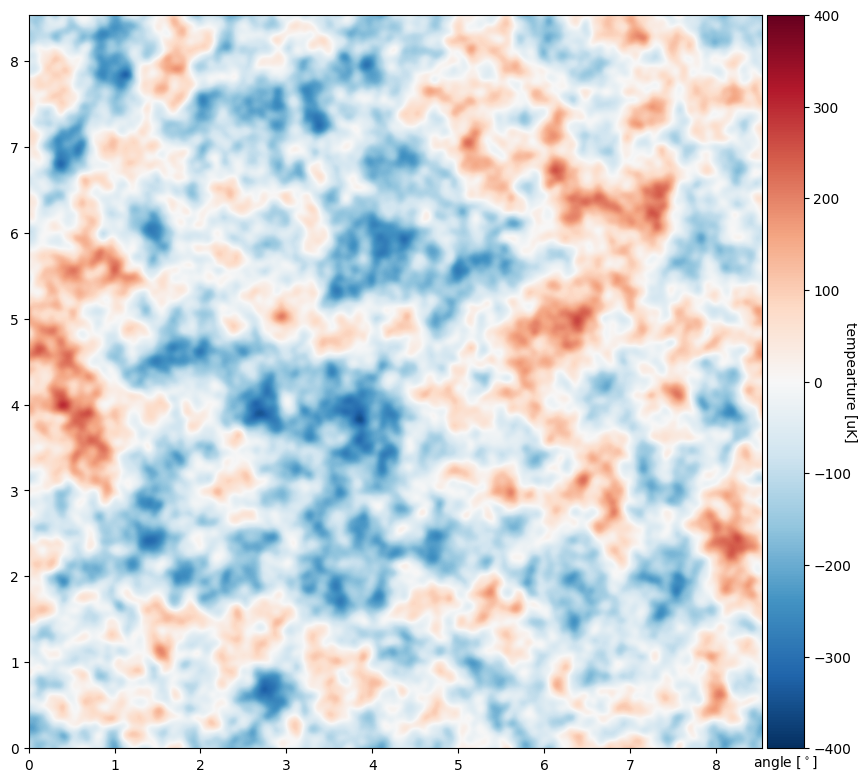

<Figure size 640x480 with 0 Axes>

In [13]:
## variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_CMB_T_map(N,pix_size,ell,DlTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    # plt.imshow(np.log(CLTT2d),cmap=cm.Blues)
    # plt.xlim(350,650)
    # plt.ylim(350,650)
    # plt.show()
        
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    plt.imshow(np.real(FT_2d))
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    
    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

def Plot_CMB_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    
    plt.show()
  ###############################

## make a CMB T map
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
Plot_CMB_Map(CMB_T,c_min,c_max,X_width,Y_width)
plt.clf()


This plot shows the simulated CMB map we just generated.  If you generate it multiple times you will find that you get different patterns, however you will see that the typical size of the brightest and darkest spots will stay around $1^\circ$, corresponding to the peak of the angular power spectrum.  All simulated sky maps are displayed with the same color scale to permit visual comparison.

<font color='red'>EXERCISE 1.3: </font>  Make a function called "make_CMB_T_map_visualize_steps" by copying the code from "make_CMB_T_map" above and changing the function name.  In this version, make a contour plot of (1) the 2D CMB power spectrum and (2) your realization of the spectrum in harmonic space.   Run this multiple times to see how your realization changes at each iteration.

In [14]:
# YOUR CODE GOES HERE

Discuss: (1)  how the CMB power sepctrum related to the realization, and (2) how the realization in harmonic space relates to the CMB map.

<font color='red'>EXERCISE 1.4: </font>  Re-run your code with the spectrum from your strange model universe.  Compare how the maps look. How does the map produced change if you set the original power spectrum to zero on small scales (eg. $\ell > 1000$)? And if you set all large scales to zero?

In [15]:
# YOUR CODE GOES HERE